# Accessing and Processing Cabled Profiler Optical Absorption and Attenuation (OPTAA) Data from OOI

OOI uses the [Sea-Bird Electronics, AC-S In-Situ Spectrophotometer](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) to measure the in situ absorption and beam attenuation coefficients from approximately 400 to 750 nm at a 4 nm resolution. Each sensor is equipped with a unique filter set that determines the exact wavelengths measured and the total number of wavelengths measured. This difference in the number of measured wavelengths and, to a certain extent, their specific values can cause complications when trying to compare measurements across deployments. One solution, presented here, is to reset the number of wavelengths for each unique instrument/deployment instance using fill values to pad out the number of wavelengths and the absorption and beam attenuation measurements to a fixed number of wavelengths. This creates a common dimension for the number of wavelengths that can be used when subsequently concatenating data across deployments.

 to demonstrate how to process AC-S data from the [Cabled Array Shallow Profilers, e.g., CE04OSPS](https://oceanobservatories.org/site/ce04osps/). 

This example develops off of the [process_kdata_optaa notebook](process_kdata_optaa.ipynb) to demonstrate the steps a user would use to access and process the [Sea-Bird Scientific AC-S](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) (known as the OPTAA in OOI-speak) from one of the [Cabled Array Shallow Profilers, e.g., CE04OSPS](https://oceanobservatories.org/site/ce04osps/). 

The benefit to using the local data directory, as opposed to the Gold Copy THREDDS catalog or the OOI M2M system is the speed of access to the data. In the M2M system, each and every user request for the data requires the system to collect, process and format the data prior to delivery. For complex data, or data that requires extensive processing, this time can be quite lengthy. With the Gold Copy THREDDS catalog, those requests have already been done for you and you can just start with downloading the data, but there is still a cost to downloading files over the internet. With local directory access, the data files can be directly loaded from disk with no need to download them from a remote server. This becomes more important when working with the higher volume cabled array data.

Note, this example will only work on the OOI JupyterHub where we have access to the kdata directory. If you want to run this code from your home or work computer, simply replace the `load_kdata` function calls with `load_gc_thredds`.

In [1]:
# load the needed processing modules
import os

from ooi_data_explorations.common import get_vocabulary, load_kdata, update_dataset, ENCODINGS
from ooi_data_explorations.cabled.process_optaa import optaa_profiler

from matplotlib import pyplot as plt

In [2]:
# Setup needed parameters for the request, the user would need to vary these to suit their own needs and
# sites/instruments of interest. Site, node, sensor, stream and delivery method names can be obtained from the
# Ocean Observatories Initiative web site. The last two will set path and naming conventions to save the data
# to the local disk
site = 'CE04OSPS'                               # OOI Net site designator
node = 'SF01B'                                  # OOI Net node designator
sensor = '3B-OPTAAD105'                         # OOI Net sensor designator
method = 'streamed'                             # OOI Net data delivery method
stream = 'optaa_sample'                         # OOI Net stream name
level = 'profiler'                              # local directory name, level below site
instrmt = 'optaa'                               # local directory name, instrument below level
deploy = 6                                      # Use data from Deployment 6
tag = 'deployment{:04d}*OPTAA*.nc'.format(deploy)  # create a file globbing tag to select the data to download
vocab = get_vocabulary(site, node, sensor)[0]

# set up the calibration file path and name
cal_path = os.path.join(os.path.expanduser('~'), 'acs_workshop/data/reprocess', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

In [3]:
%%time
# load data from the local kdata directory
optaa = load_kdata(site, node, sensor, method, stream, tag)

Loading and Processing Data Files: 100%|██████████| 11/11 [00:20<00:00,  1.87s/it]
Merging the data files into a single dataset
CPU times: user 9.2 s, sys: 18.3 s, total: 27.5 s
Wall time: 35.7 s


In [4]:
# view the dataset as downloaded from OOI (with some minor modifications, e.g. switching dimensions from obs to time)
optaa

<xarray.Dataset> Size: 11GB
Dimensions:                       (time: 3070970, wavelength: 88, string3: 3)
Coordinates:
  * wavelength                    (wavelength) int32 352B 0 1 2 3 ... 85 86 87
  * time                          (time) datetime64[ns] 25MB 2019-06-14T19:22...
Dimensions without coordinates: string3
Data variables: (12/30)
    external_temp_raw             (time) uint16 6MB 40814 40817 ... 40207 40212
    c_signal_counts               (time, wavelength) uint16 540MB 1118 ... 5996
    deployment                    (time) int32 12MB 6 6 6 6 6 6 ... 6 6 6 6 6 6
    a_signal_counts               (time, wavelength) uint16 540MB 973 ... 5514
    lat                           (time) float64 25MB 44.37 44.37 ... 44.37
    int_ctd_pressure              (time) float64 25MB 198.4 198.4 ... 195.2
    ...                            ...
    a_signal_dark_counts          (time) uint16 6MB 700 700 700 ... 710 710 710
    c_reference_counts            (time, wavelength) uint16 540MB 1346 ... 7848
    a_reference_dark_counts       (time) uint16 6MB 470 469 469 ... 465 464 464
    checksum                      (time) uint16 6MB 65535 65535 ... 65535 65535
    depth                         (time) float64 25MB 196.7 196.7 ... 193.5
    sea_water_temperature         (time) float64 25MB 6.944 6.944 ... 7.753
Attributes: (12/67)
    node:                               SF01B
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             optaa_sample
    ...                                 ...
    geospatial_lon_max:                 -124.956429
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

You can just start working with the OOI OPTAA data as-is at this point. However, the OOI OPTAA data sets do not include data products from the intermediate optical absorption and beam attenuation processing steps, where:

- the data has been converted from the raw, but has not been corrected for the effects of temperature and salinity or scattering
- the data has been corrected for the effects of temperature and salinity, but the scattering correction has not been applied to the optical absorption data
- the optical absorption data has been corrected for effects of scattering (this example utilizes the baseline scatter correction method)

Instead the OOI OPTAA only has the raw data and the final, temperature, salinity and scatter corrected data. It is considered good practice to make the intermediate data products available to users, especially more advanced users wishing to assess different methods for the scatter corrections. Additionally, if corrections to the spectra are required, using offsets determined by pre-deployment calibrations, these intermediate data products will be needed.

The `process_optaa` module (with different processing functions based on the platform the AC-S was deployed on) has been set up to recalculate these intermediate products starting from the raw measurements. Additionally, the scattering correction has been switched to the simpler [Baseline Correction](https://ioccg.org/wp-content/uploads/2020/09/absorption_protocol_final-incl-cover_rev.pdf) method from the more complicated [modified proportional method](https://github.com/cwingard/ion-functions/blob/master/ion_functions/data/opt_functions.py#L508) employed by OOI. This simpler algorithm tends to be more robust across all deployments, but arguments can be made for trying different methods. With the reprocessed data, the option to try different scatter correction methods is now a much simpler process.

Additionally, profiling datasets created by OOI do not include a way to distinguish between profiles. We can use the profiler pressure record to construct a `profile` variable that we can later use to sub-select unique profiles for examination.

In order to create these intermediate data products, we first need to download the vendor calibration data for the instrument from the OOI Asset Management records accessible via the OOI M2M system. The `cal_file` variable created above will hold this data. The first time the calibration data is downloaded, this file will be created. After that, the code will reuse the already downloaded data. The calibration data is saved in a `JSON` formatted data file, making the data both human and machine readable.

In [5]:
%%time
# clean-up and reorganize the profiler data (create a profile ID and bin the data into 25 cm bins for each profile)
optaa = optaa_profiler(optaa, cal_file)

Determining profiler movement ...
Profiler moved during the deployment, treating data as a series of profiles.
Sub-selecting upcast data only from the data set ...
Creating and adding a profile variable to the data set ...
Smoothing and binning each profile into 25 cm depth bins ...: 100%|██████████| 178/178 [03:20<00:00,  1.13s/it]
Re-processing the raw data, creating intermediate data products ...


Converting attenuation data ...: 100%|██████████| 116264/116264 [00:17<00:00, 6796.60it/s]


CPU times: user 2min 42s, sys: 24.2 s, total: 3min 6s
Wall time: 6min 11s


In [6]:
# show the results of the re-processed data in comparison to the original
optaa

<xarray.Dataset> Size: 1GB
Dimensions:                       (time: 116264, wavelength_number: 100)
Coordinates:
  * time                          (time) datetime64[ns] 930kB 2019-06-14T19:2...
  * wavelength_number             (wavelength_number) int64 800B 0 1 2 ... 98 99
Data variables: (12/38)
    external_temp_raw             (time) int64 930kB 40768 40855 ... 39017 40208
    deployment                    (time) int64 930kB 6 6 6 6 6 6 ... 6 6 6 6 6 6
    lat                           (time) float64 930kB 44.37 44.37 ... 44.37
    sea_water_pressure            (time) float64 930kB 198.4 193.4 ... 195.2
    elapsed_run_time              (time) float64 930kB 3.709e+05 ... 3.73e+06
    lon                           (time) float64 930kB -125.0 -125.0 ... -125.0
    ...                            ...
    wavelength_c                  (time, wavelength_number) float64 93MB 399....
    c_signal                      (time, wavelength_number) int64 93MB 1086 ....
    c_reference                   (time, wavelength_number) int64 93MB 1311 ....
    beam_attenuation              (time, wavelength_number) float64 93MB nan ...
    cpg                           (time, wavelength_number) float64 93MB 0.16...
    cpg_ts                        (time, wavelength_number) float64 93MB nan ...
Attributes: (12/67)
    node:                               SF01B
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             optaa_sample
    ...                                 ...
    geospatial_lon_max:                 -124.956429
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

## Save the data for future work

At this point the optaa record is at a point where it can be saved locally or used in further work looking across deployments or between sites. Some of the work one might want to do is a review of the data by comparing the instrument temperature records versus the co-located CTD data, by computing different parameters (chlorophyll concentration, POC, and absorption ratios) from the absorption and attenuation records and by reviewing the shape and magnitude of the aborption and attenuation spectra.

In [7]:
nc_file = ('{}.{}.{}.deploy{:02d}.reprocessed.nc'.format(site.lower(), level, instrmt, deploy))
nc_file = os.path.join(cal_path, nc_file)
optaa.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')

In [8]:
# split the data into profiles using the profile variable added in the above processing
profiles = optaa.groupby('profile')
profiles[30]

<xarray.Dataset> Size: 7MB
Dimensions:                       (time: 671, wavelength_number: 100)
Coordinates:
  * time                          (time) datetime64[ns] 5kB 2019-07-10T07:22:...
  * wavelength_number             (wavelength_number) int64 800B 0 1 2 ... 98 99
Data variables: (12/38)
    external_temp_raw             (time) int64 5kB 40615 40614 ... 39161 39148
    deployment                    (time) int64 5kB 6 6 6 6 6 6 6 ... 6 6 6 6 6 6
    lat                           (time) float64 5kB 44.37 44.37 ... 44.37 44.37
    sea_water_pressure            (time) float64 5kB 193.7 193.4 ... 24.93 24.7
    elapsed_run_time              (time) float64 5kB 7.559e+04 ... 3.774e+06
    lon                           (time) float64 5kB -125.0 -125.0 ... -125.0
    ...                            ...
    wavelength_c                  (time, wavelength_number) float64 537kB 399...
    c_signal                      (time, wavelength_number) int64 537kB 1052 ...
    c_reference                   (time, wavelength_number) int64 537kB 1278 ...
    beam_attenuation              (time, wavelength_number) float64 537kB nan...
    cpg                           (time, wavelength_number) float64 537kB 0.1...
    cpg_ts                        (time, wavelength_number) float64 537kB nan...
Attributes: (12/67)
    node:                               SF01B
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             optaa_sample
    ...                                 ...
    geospatial_lon_max:                 -124.956429
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

The CTD seawater temperature and the instrument internal temperature are inputs to the functions used to calculate the optical absorption and beam attenuation. The data from the external temperature sensor on the AC-S is not used, but it should be producing values very close to the CTD (the AC-S temperaure sensor is not as accurate as the CTD). All three measurements should be very similar. If they are not, that might be an indication that there is a problem with one of the sensors.

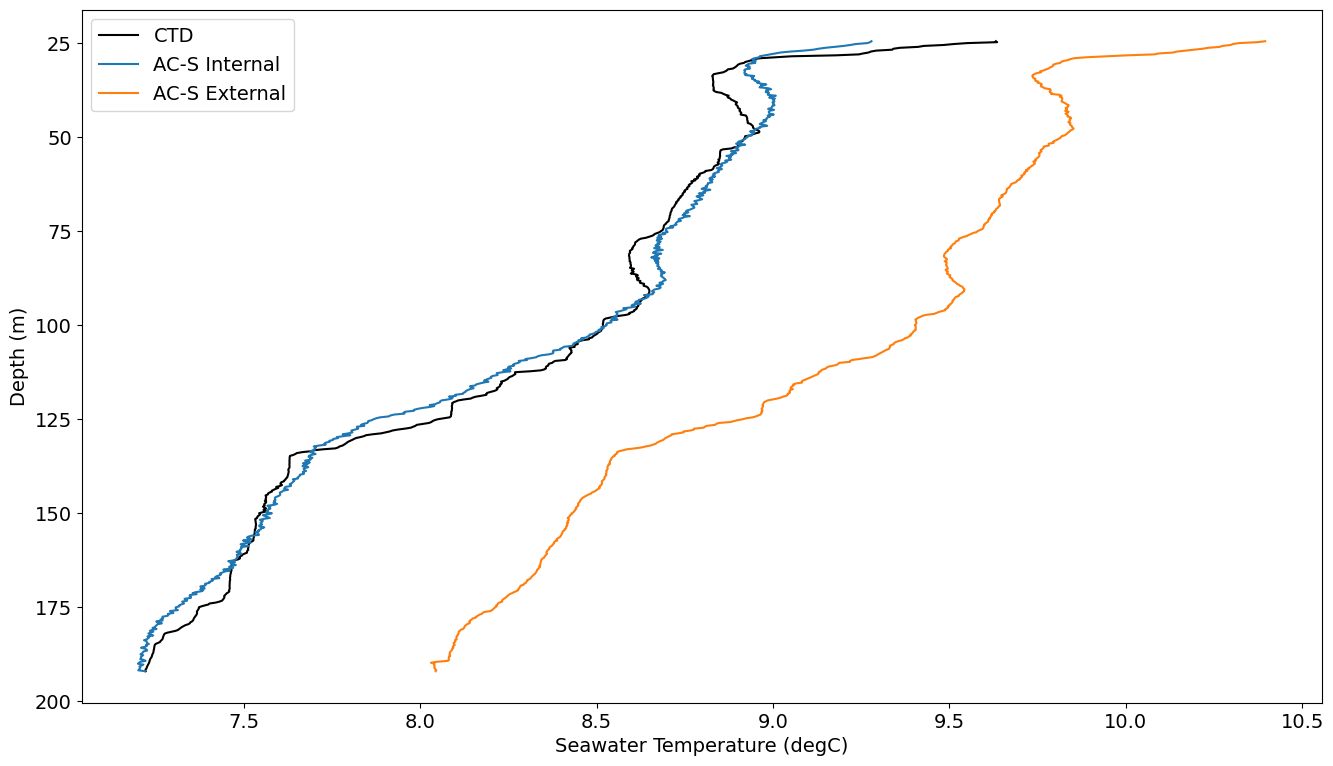

In [9]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records for profile 10
profile = profiles[30]
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(profile['sea_water_temperature'], profile['depth'], '-k', label='CTD')
plt.plot(profile['internal_temp'], profile['depth'], label='AC-S Internal')
plt.plot(profile['external_temp'], profile['depth'], label='AC-S External')
plt.gca().invert_yaxis()
plt.xlabel('Seawater Temperature (degC)')
plt.ylabel('Depth (m)')
plt.legend()

There is clearly an offset between the AC-S external temperature sensor and the CTD. As noted above, the external temperature sensor on the AC-S is not the most accurate. Additionally, there is a clear lag between the two pressure sensors. Most likely, this is a depth offset due to where the sensors are installed in the shallow profiler. A true analysis of this data would need to take this offset into account prior to calculating the temperature and salinity corrections. For this notebook, however, we will simply use the data as-is.

The AC-S data can be used to create estimates of the chlorophyll and particulate organic carbon (POC) concentration. These can be compared to data from a co-located fluorometer to help validate the performance of the sensors. Additionally, pigment ratios can be calculated to assess the impacts of biofouling, potential changes in community composition, light history or bloom health and age.

* CDOM Ratio -- ratio of CDOM absorption in the violet portion of the spectrum at 412 nm relative to chlorophyll absorption at 440 nm. Ratios greater than 1 indicate a preponderance of CDOM absorption relative to chlorophyll.
* Carotenoid Ratio -- ratio of carotenoid absorption in the blue-green portion of the spectrum at 490 nm relative to chlorophyll absorption at 440 nm. A changing carotenoid to chlorophyll ratio may indicate a shift in phytoplankton community composition in addition to changes in light history or bloom health and age.
* Phycobilin Ratio -- ratio of phycobilin absorption in the green portion of the spectrum at 530 nm relative to chlorophyll absorption at 440 nm. Different phytoplankton, notably cyanobacteria, utilize phycobilins as accessory light harvesting pigments. An increasing phycobilin to chlorophyll ratio may indicate a shift in phytoplankton community composition.
* Q Band Ratio -- the Soret and the Q bands represent the two main absorption bands of chlorophyll. The former covers absorption in the blue region of the spectrum, while the latter covers absorption in the red region. A decrease in the ratio of the intensity of the Soret band at 440 nm to that of the Q band at 676 nm may indicate a change in phytoplankton community structure. All phytoplankton contain chlorophyll a as the primary light harvesting pigment, but green algae and dinoflagellates contain chlorophyll b and c, respectively, which are spectrally redshifted compared to chlorophyll a.

Before we look at the estimated chlorophyll and POC data, it will be helpful to pull in data from the co-located Sea-Bird Electronics ECO Triplet (FLORT). This data can also be used to create estimates of chlorophyll and POC, which can then be cross-compared to the AC-S estimates. This provides a useful means of validating the data.

In [10]:
%%time
from ooi_data_explorations.cabled.process_flort import flort_profiler

# Setup needed parameters for the request
site = 'CE04OSPS'           # OOI Net site designator
node = 'SF01B'              # OOI Net node designator
sensor = '3A-FLORTD104'     # OOI Net sensor designator
stream = 'flort_d_data_record'  # OOI Net stream name
method = 'streamed'         # OOI Net data delivery method
instrmt = 'flort'           # local directory name, instrument below level
tag = 'deployment{:04d}*FLORT*.nc'.format(deploy)  # create a regex tag to select the data to download

# We are after the the data from deployment 3
vocab = get_vocabulary(site, node, sensor)[0]

# load data from the local kdata directory
flort = load_kdata(site, node, sensor, method, stream, tag)
flort = flort_profiler(flort)

# create an estimate of POC from the particulate backscatter data
flort['estimated_poc'] = 43317 * (flort['bback'] - flort['sea_water_scattering_coefficient'])  # derived from Cetinic et al., 2012 (upcast slope from NAB08, but not the offset)

Loading and Processing Data Files: 100%|██████████| 4/4 [00:55<00:00, 13.88s/it]


Merging the data files into a single dataset
CPU times: user 22.4 s, sys: 3.3 s, total: 25.7 s
Wall time: 1min 3s


In [11]:
# show the FLORT dataset
flort

<xarray.Dataset> Size: 1GB
Dimensions:                                     (time: 8288048)
Coordinates:
  * time                                        (time) datetime64[ns] 66MB 20...
Data variables: (12/35)
    estimated_chlorophyll_qc_results            (time) uint8 8MB 13 13 ... 28 29
    fluorometric_cdom                           (time) float64 66MB 0.9698 .....
    fluorometric_cdom_qc_executed               (time) uint8 8MB 29 29 ... 29 29
    fluorometric_cdom_qartod_results            (time) uint8 8MB 1 1 1 ... 1 1 1
    fluorometric_chlorophyll_a_qartod_results   (time) uint8 8MB 1 1 1 ... 1 4 1
    fluorometric_cdom_qartod_executed           (time) <U1 33MB '1' '1' ... '1'
    ...                                          ...
    sea_water_temperature                       (time) float64 66MB 6.944 ......
    estimated_chlorophyll_qc_summary_flag       (time) int32 33MB 3 3 3 ... 4 1
    bback_qc_summary_flag                       (time) int32 33MB 3 3 3 ... 3 3
    beta_700_qc_summary_flag                    (time) int32 33MB 3 3 3 ... 3 3
    fluorometric_cdom_qc_summary_flag           (time) int32 33MB 1 1 1 ... 1 1
    estimated_poc                               (time) float64 66MB 40.82 ......
Attributes: (12/67)
    node:                               SF01B
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             flort_d_data_record
    ...                                 ...
    geospatial_lon_max:                 -124.956429
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [12]:
# add the estimated chlorophyll and POC from the FLORT data to the AC-S data
import numpy as np
chl = np.interp(optaa.time.astype(float), flort.time.astype(float), flort.estimated_chlorophyll)
poc = np.interp(optaa.time.astype(float), flort.time.astype(float), flort.estimated_poc)

optaa['fluorometric_chlorophyll'] = ('time', chl)
optaa['backscatter_poc'] = ('time', poc)
profiles = optaa.groupby('profile')
profile = profiles[30]

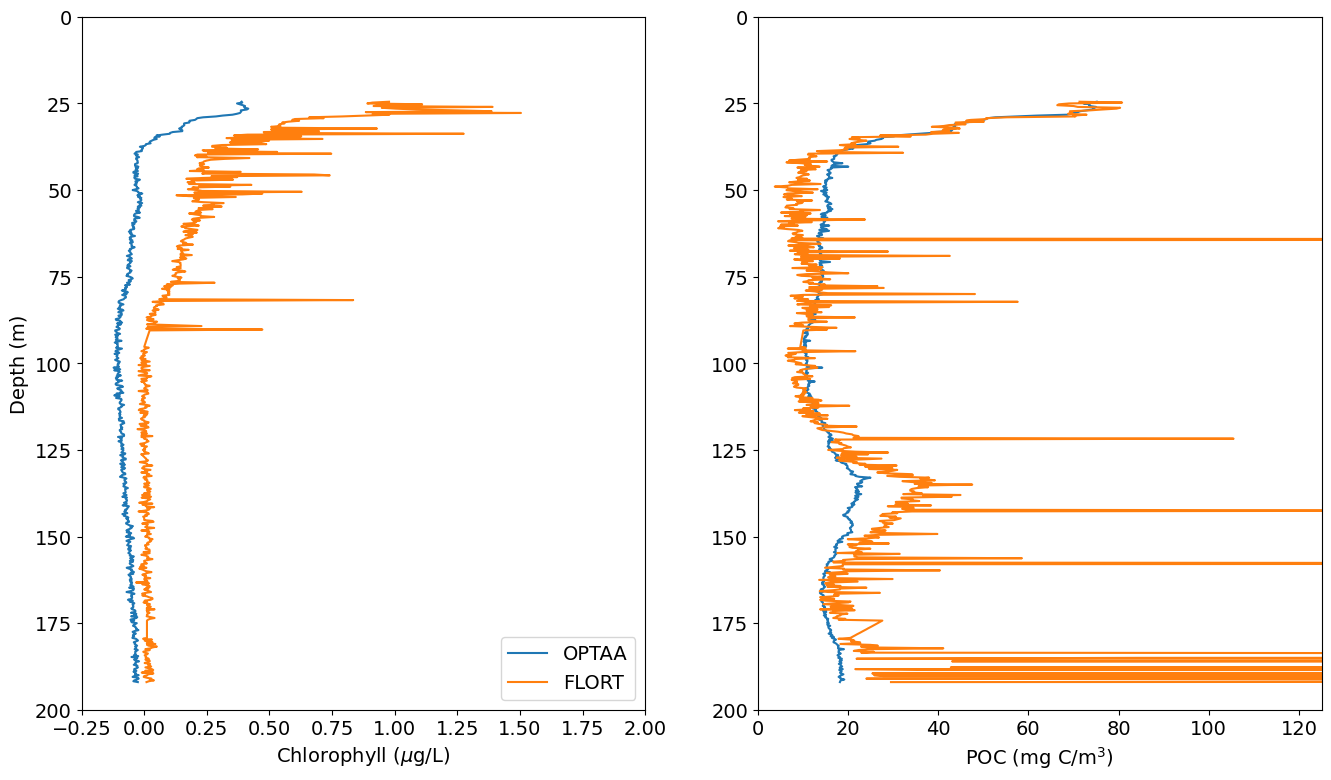

In [13]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(121)
plt.plot(profile['estimated_chlorophyll'], profile['depth'], label='OPTAA')
plt.plot(profile['fluorometric_chlorophyll'], profile['depth'], label='FLORT')
plt.xlabel('Chlorophyll ($\mu$g/L)')
plt.ylabel('Depth (m)')
plt.xlim([-0.25, 2])
plt.ylim([0, 200])
plt.legend(loc='lower right')

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(profile['estimated_poc'], profile['depth'])
plt.plot(profile['backscatter_poc'], profile['depth'])
plt.xlabel('POC (mg C/m$^3$)')
plt.xlim([0, 125])
plt.ylim([0, 200])
plt.gca().invert_yaxis()
plt.show()

While we see reasonbale agreement with the estimated POC (note, a single slope may not be valid as the POC/bbp slope decreases below the pycnocline, due to changing particle structure, Cetinic et al., 2012), we do not see good agreement with estimated chlorophyll data. The question is why. Looking at the shape of the absorption spectra can help to figure this discrepancy out.

Text(0.5, 1.0, 'Recalculated Attenuation Data')

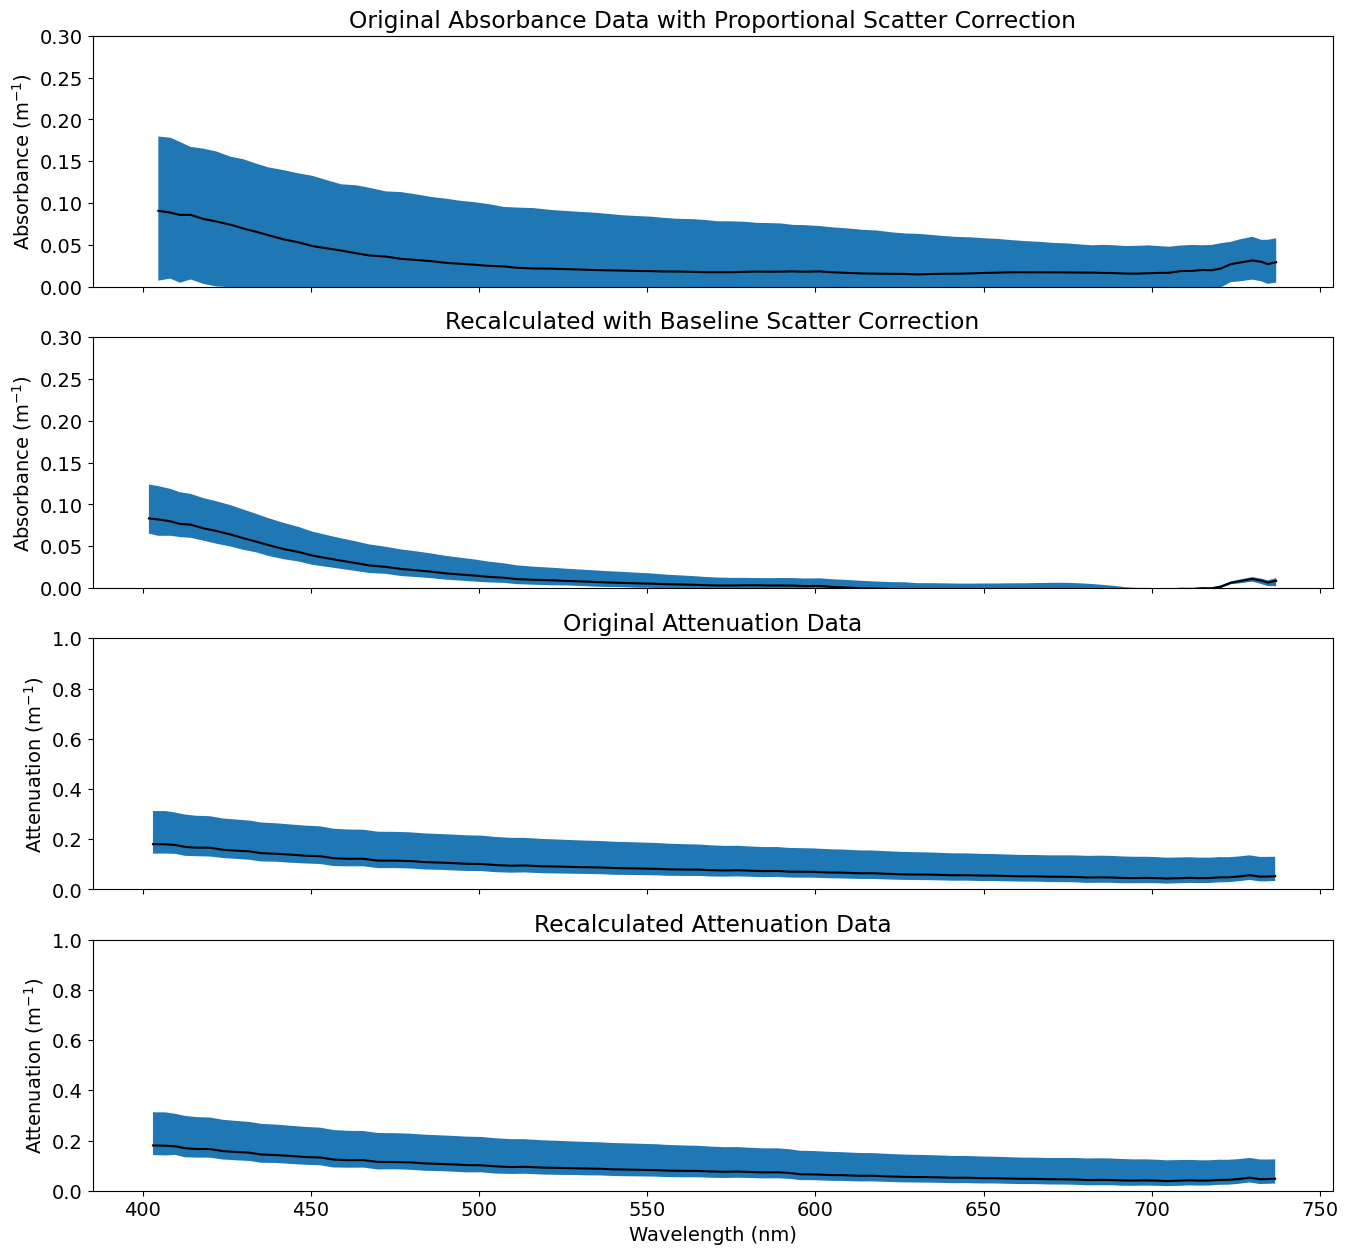

In [17]:
# plot the optical absortion and attenuation spectra (as calculated by OOI and as recalculated here)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,15))

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message='Degrees of freedom <= 0 for slice.')

ax1 = plt.subplot(411)
plt.plot(profile['wavelength_a'][0, :], profile['optical_absorption'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['optical_absorption'].min(axis=0), 
                 profile['optical_absorption'].mean(axis=0) + profile['optical_absorption'].std(axis=0) * 3)
plt.ylim([0, 0.3])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Original Absorbance Data with Proportional Scatter Correction')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(profile['wavelength_a'][0, :], profile['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['apg_ts_s'].min(axis=0), 
                 profile['apg_ts_s'].mean(axis=0) + profile['apg_ts_s'].std(axis=0) * 3)
plt.ylim([0, 0.3])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Recalculated with Baseline Scatter Correction')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['beam_attenuation'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['beam_attenuation'].min(axis=0), 
                 profile['beam_attenuation'].mean(axis=0) + profile['beam_attenuation'].std(axis=0) * 3)
plt.ylim([0, 1])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.title('Original Attenuation Data')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['cpg_ts'].min(axis=0), 
                 profile['cpg_ts'].mean(axis=0) + profile['cpg_ts'].std(axis=0) * 3)
plt.ylim([0, 1])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.title('Recalculated Attenuation Data')

Based on the shape of the above spectra, the optical absorption spectra looks to be unreasonable (downshifted, especially in the blue portion of the spectra). The optical attenuation data looks reasonable, and given the agreement with the backscatter derived POC estimates, we could use the attenuation data as-s. This dataset, however, looks like it needs to be corrected using the pre-deployment pure-water calibration. For an example of how that could be done, see the [processing_workflow_using_the_cspp_optaa.ipynb](processing_workflow_using_the_cspp_optaa.ipynb) notebook.

For now, let's see what a slice of the data at 10 m looks like...

In [18]:
# create a slice at 10 m for the entire deployment
slice10 = optaa.where((optaa['depth'] >= 9.75) & (optaa['depth'] <= 10.25), drop=True)

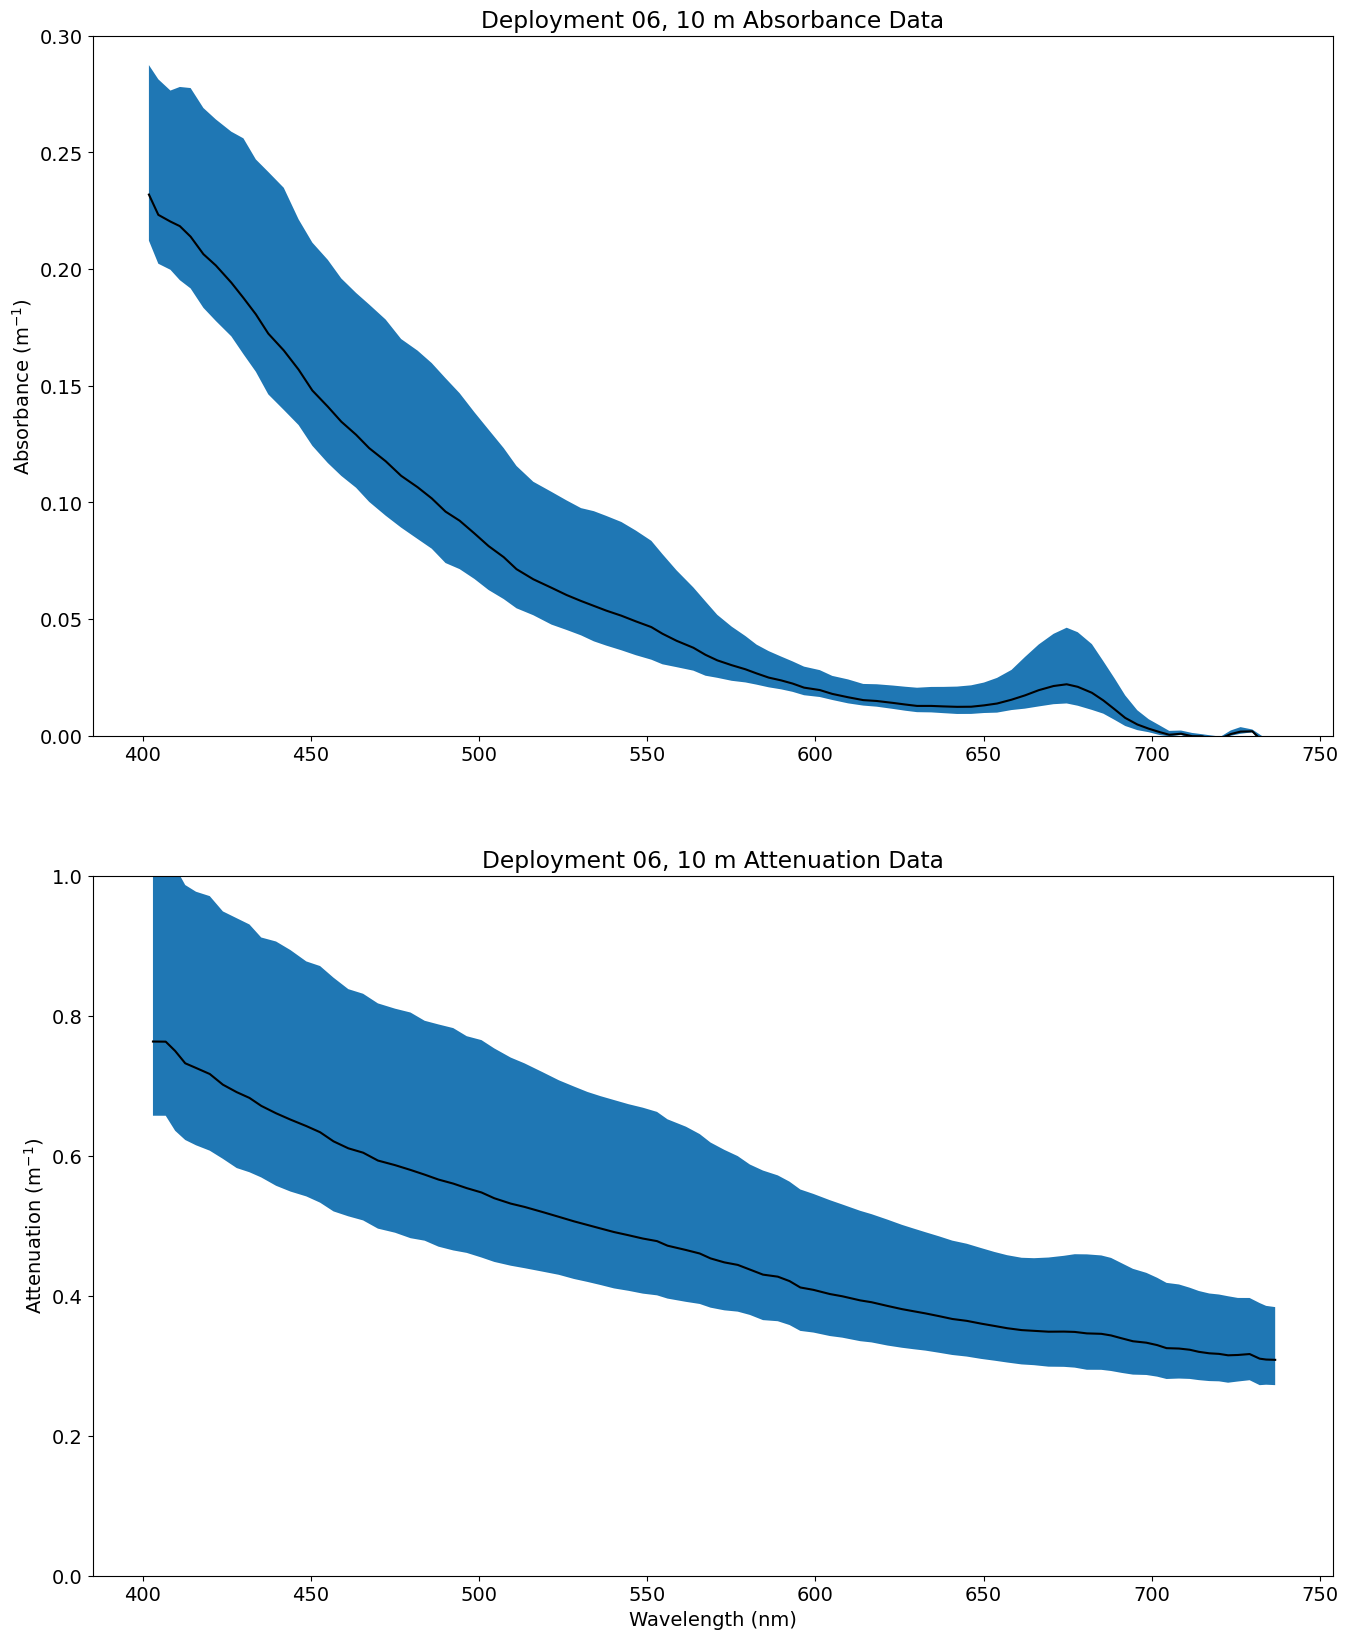

In [19]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,20))

ax1 = plt.subplot(211)
plt.plot(slice10['wavelength_a'][0, :], slice10['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_a'][0, :], slice10['apg_ts_s'].min(axis=0), 
                 slice10['apg_ts_s'].mean(axis=0) + (slice10['apg_ts_s'].std(axis=0) * 3))
plt.ylim([0, 0.30])
plt.title('Deployment 06, 10 m Absorbance Data')
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(slice10['wavelength_c'][0, :], slice10['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_c'][0, :], slice10['cpg_ts'].min(axis=0), 
                 slice10['cpg_ts'].mean(axis=0) + (slice10['cpg_ts'].std(axis=0) * 3))
plt.ylim([0, 1])
plt.title('Deployment 06, 10 m Attenuation Data')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.show()